In [23]:
!pip install -q split-folders

In [24]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import splitfolders
import glob

from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

TensorFlow version: 2.4.1


## Flowers dataset overview

### Total number of images and by per category

In [25]:
path = '../input/flowers-recognition/flowers'
categories = os.listdir(path)

print('Total number of images:', sum([len(os.listdir(path + '/' + cat)) for cat in categories]))
print('\nFlowers categories:', len(categories), categories)
print('\nTotal number images by each category:')
print('Dandelion images:', len(os.listdir(path + '/dandelion')))
print('Daisy images:    ', len(os.listdir(path + '/daisy')))
print('Sunflower images:', len(os.listdir(path + '/sunflower')))
print('Tulip images:    ', len(os.listdir(path + '/tulip')))
print('Rose images:     ', len(os.listdir(path + '/rose')))

Total number of images: 4317

Flowers categories: 5 ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

Total number images by each category:
Dandelion images: 1052
Daisy images:     764
Sunflower images: 733
Tulip images:     984
Rose images:      784


### Resolution of the images

In [26]:
%%time

img_shapes = {"height": [], "width": []}

for cat in categories:
    filelist = glob.glob(path + '/' + cat + '/*.jpg')
    for fname in filelist:
        img_shapes["height"].append(np.array(Image.open(fname)).shape[0])
        img_shapes["width"].append(np.array(Image.open(fname)).shape[1])

CPU times: user 21.1 s, sys: 533 ms, total: 21.7 s
Wall time: 24.9 s


In [27]:
df_img_sizes = pd.DataFrame(img_shapes)
print(df_img_sizes.shape)
df_img_sizes.describe()

(4317, 2)


height        width
count  4317.000000  4317.000000
mean    253.073662   338.379893
std      61.558205   119.067232
min      80.000000   134.000000
25%     214.000000   240.000000
50%     240.000000   320.000000
75%     329.000000   500.000000
max     442.000000  1024.000000

array([[<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'width'}>]], dtype=object)

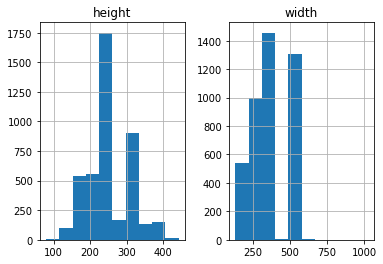

In [28]:
df_img_sizes.hist()

In [29]:
#Let's take the most popular resolutions according to the histogram
IMG_HEIGHT = 240
IMG_WIDTH = 260

In [30]:
def draw_flowers(category):
    rose_dir = path + '/' + category
    rose_files = os.listdir(path + '/' + category)

    # Output images in a 4x4 configuration
    nrows = 4
    ncols = 4
    pic_index = 8


    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    next_rose_img = [os.path.join(rose_dir, fname) 
                    for fname in rose_files[:pic_index]]

    for i, img_path in enumerate(next_rose_img):
      sp = plt.subplot(nrows, ncols, i + 1)
      sp.axis('Off')

      img = mpimg.imread(img_path)
      plt.imshow(img)

    plt.show()

### Dandelion

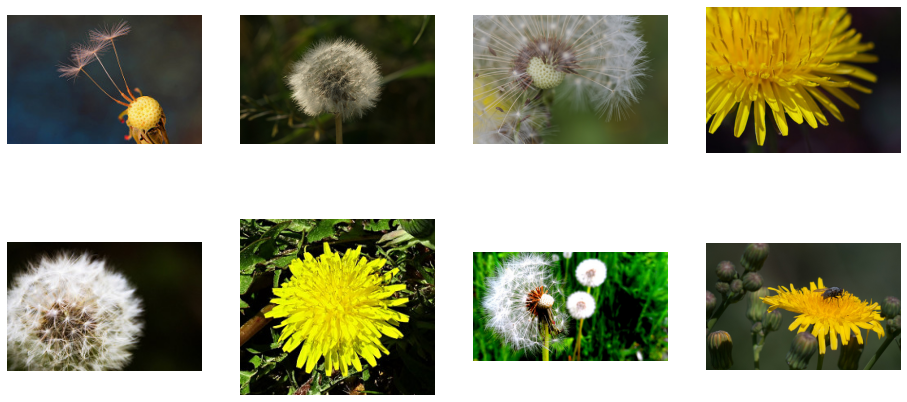

In [31]:
draw_flowers('dandelion')

### Daisy

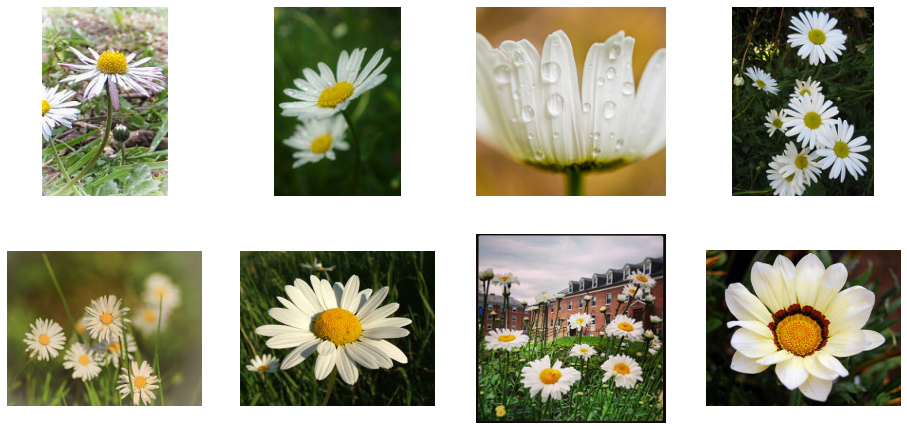

In [32]:
draw_flowers('daisy')

### Sunflower

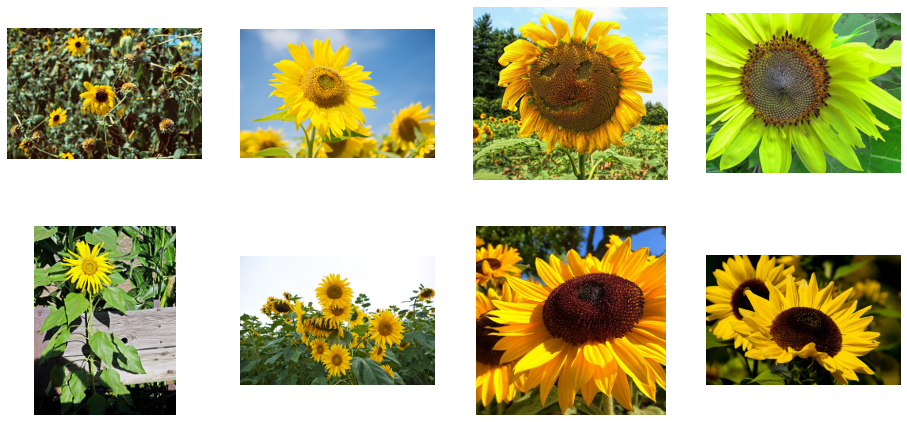

In [33]:
draw_flowers('sunflower')

### Tulip

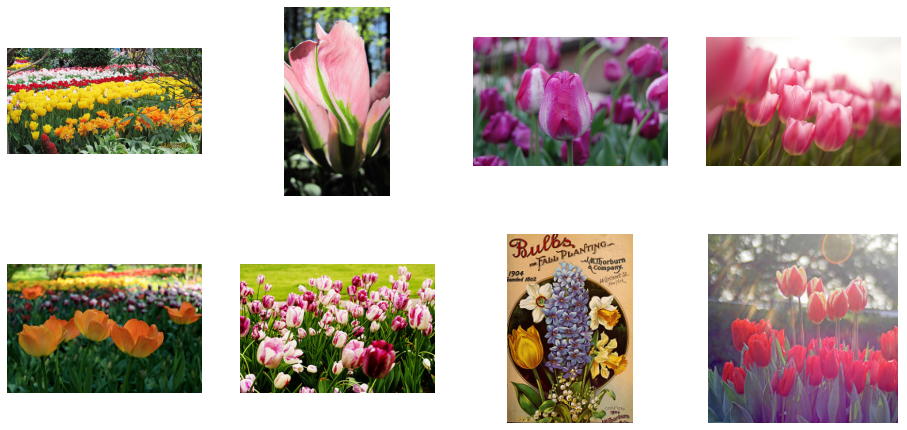

In [34]:
draw_flowers('tulip')

### Rose

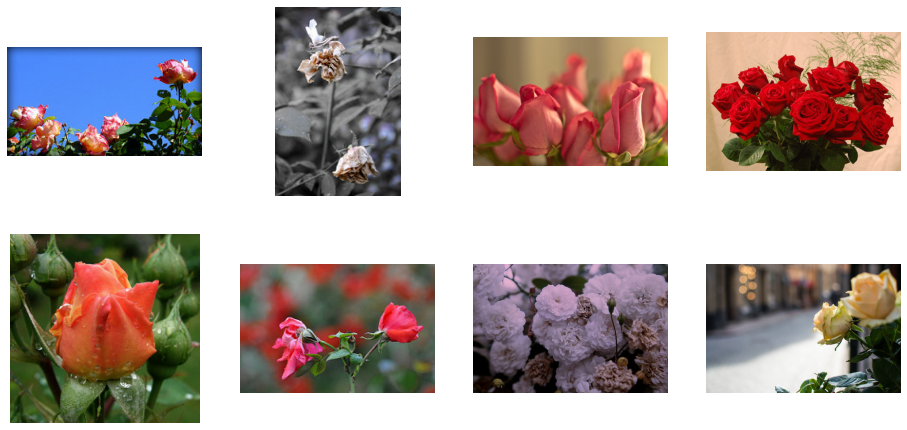

In [35]:
draw_flowers('rose')

## Split data into train, validation and test sets

In [36]:
splitfolders.ratio(path, output="output", seed=100, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 4317 files [00:03, 1278.97 files/s]


In [37]:
path_train = 'output/train/'
path_valid = 'output/val/'
path_test = 'output/test/'
print('Train images:', sum([len(os.listdir(path_train + cat)) for cat in categories]))
print('Valid images:', sum([len(os.listdir(path_valid + cat)) for cat in categories]))
print('Test  images:', sum([len(os.listdir(path_test + cat)) for cat in categories]))

Train images: 2588
Valid images: 860
Test  images: 869


## ImageDataGenerator

In [38]:
BATCH_SIZE_TRAIN = 64

train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    path_train,  
    target_size=(IMG_WIDTH, IMG_HEIGHT),  
    batch_size=BATCH_SIZE_TRAIN,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    path_valid,  
    target_size=(IMG_WIDTH, IMG_HEIGHT),  
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical'
)

Found 2588 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Found 869 images belonging to 5 classes.


## Model

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    
    # Data Augmentation
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)),# OK! very good
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'), # OK, it increases acc
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3)), #OK.., it increases acc
    tf.keras.layers.experimental.preprocessing.RandomContrast(.4, .7), #?? .., it increases acc little bit
    tf.keras.layers.experimental.preprocessing.RandomZoom(.2, .2), # OK
    
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.MaxPooling2D(2,2), 
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=.2),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_translation_1 (Random (None, 260, 240, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 260, 240, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 260, 240, 3)       0         
_________________________________________________________________
random_contrast_1 (RandomCon (None, 260, 240, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 260, 240, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 258, 238, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 258, 238, 32)     

#### Compile

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              #optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

#### Callback function for early stopping

In [41]:
DESIRED_ACCURACY = 0.98
  
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > DESIRED_ACCURACY):
            print("\nReached {}% accuracy so cancelling training!".format(DESIRED_ACCURACY))
            self.model.stop_training = True
        
callb = MyCallback()

### Train

In [42]:
%%time

epochs=200

history = model.fit(
      train_generator, 
      epochs=epochs,
      verbose=1,
      validation_data = valid_generator,
      validation_steps=8,
      callbacks=[callb])

Epoch 1/200
41/41 [==============================] - 17s 344ms/step - loss: 1.5868 - accuracy: 0.2844 - val_loss: 1.3736 - val_accuracy: 0.4180
Epoch 2/200
41/41 [==============================] - 13s 327ms/step - loss: 1.5036 - accuracy: 0.4030 - val_loss: 1.2356 - val_accuracy: 0.4883
Epoch 3/200
41/41 [==============================] - 14s 344ms/step - loss: 1.4019 - accuracy: 0.4114 - val_loss: 1.2365 - val_accuracy: 0.4258
Epoch 4/200
41/41 [==============================] - 13s 324ms/step - loss: 1.3201 - accuracy: 0.4461 - val_loss: 1.1106 - val_accuracy: 0.4805
Epoch 5/200
41/41 [==============================] - 14s 336ms/step - loss: 1.2999 - accuracy: 0.4585 - val_loss: 1.1383 - val_accuracy: 0.5391
Epoch 6/200
41/41 [==============================] - 13s 325ms/step - loss: 1.3161 - accuracy: 0.4589 - val_loss: 1.1764 - val_accuracy: 0.5508
Epoch 7/200
41/41 [==============================] - 13s 328ms/step - loss: 1.1926 - accuracy: 0.5104 - val_loss: 1.1620 - val_accuracy:

### Plot results

Text(0.5, 1.0, 'Train and Validation Loss')

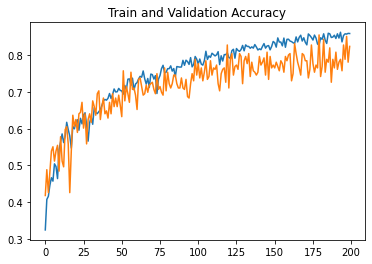

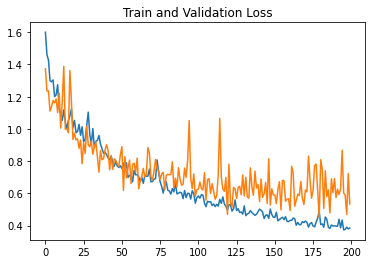

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(range(len(acc)), acc, label='Train Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Valid Accuracy')
plt.title ('Train and Validation Accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(range(len(loss)), loss, label='Train Loss')
plt.plot(range(len(val_loss)), val_loss, label='Valid Loss')
plt.title ('Train and Validation Loss'   )

In [44]:
model.evaluate(test_generator)

28/28 [==============================] - 3s 102ms/step - loss: 0.5628 - accuracy: 0.8067


[0.5628141164779663, 0.8066743612289429]


Image
